# Wettervorhersage mit Decision Tree Algorithmen
---
Das Ziel dieses Projekts besteht darin, die Niederschlags- und Lufttemperaturwerte drei Tage in die Zukunft mithilfe von Maschinelerning-Algorithmen, hier insbesondere dem Decision Tree, vorherzusagen. Die zugrundeliegenden Daten stammen aus drei verschiedenen Wetterstationen und werden in drei separaten CSV-Dateien präsentiert.

## Datenstruktur:

Jede Zeile in den CSV-Dateien repräsentiert einen Tag, wobei verschiedene meteorologische Instrumente unterschiedliche Parameter aufzeichnen. Die verfügbaren Spalten für die Vorhersage umfassen die folgenden Features:
- `DATE`
- `MESS_DATUM`
- `QUALITAETS_NIVEAU`
- `LUFTTEMPERATUR`
- `DAMPFDRUCK`
- `BEDECKUNGSGRAD`
- `LUFTDRUCK_STATIONSHOEHE`
- `REL_FEUCHTE`
- `WINDGESCHWINDIGKEIT`
- `LUFTTEMPERATUR_MAXIMUM`
- `LUFTTEMPERATUR_MINIMUM`
- `LUFTTEMP_AM_ERDB_MINIMUM`
- `WINDSPITZE_MAXIMUM`
- `NIEDERSCHLAGSHOEHE`
- `NIEDERSCHLAGSHOEHE_IND`
- `SONNENSCHEINDAUER`
- `SCHNEEHOEHE`

Es ist wichtig zu beachten, dass fehlende Daten mit dem Wert -999 gekennzeichnet sind. Weiterhin ist zu beachten, dass für jede Wetterstation nicht gleich viele Tage vorhanden sind.

## Herangehensweise:

Die Vorhersagen werden mithilfe von Decision Tree Algorithmen, speziell dem Random Forest, durchgeführt. Der Random Forest ist eine Ensemble-Methodik, die mehrere Entscheidungsbäume kombiniert, um genauere und robustere Vorhersagen zu erzielen.

## Schritte im Projekt:

1. Datenimport und -bereinigung:
   - Import der Daten aus den drei CSV-Dateien.
   - Identifizierung und Handhabung von fehlenden Daten (-999).

2. Feature-Engineering:
   - Auswahl der relevanten Merkmale (Spalten) für die Vorhersage.
   - Mögliche Transformationen oder Skalierungen der Daten für eine bessere Modellleistung.

3. Trainieren des Random Forest und verwandter Modelle:
   - Aufteilung der Daten in Trainings- und Testsets.
   - Identifizierung der besten Parameter für das Random Forest-Modell und Implementierung dieser.
   - Identifizierung der besten Parameter für das Bagging-Modell und Implementierung dieser.
   - Identifizierung der besten Parameter für das Boosting-Modell und Implementierung dieser.

4. Vorhersagen:
   - Verwendung des trainierten Modells, um die Niederschlags- und Lufttemperaturwerte für die nächsten drei Tage vorherzusagen.

5. Modellbewertung:
   - Bewertung der Vorhersagegenauigkeit anhand von Metriken wie MSE oder R-squared für die einzelnen Modelle.
   - Bewertung der Verwendbarkeit.
   - Bewertung der verwendeten Features.


In [16]:
# Import der Bibliotheken
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import linear_model

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms
import math

## Daten Importieren

In [19]:
# Seperation von Featchers und Zieldaten (x, y)

from pathlib import Path
cwd = str(Path.cwd())

X = pd.read_csv(cwd + "/../data/Featchers_randomized.csv")
Y = pd.read_csv(cwd + "/../data/Goals_randomized.csv")
D = pd.read_csv(cwd + "/../data/Timings_randomized.csv").sort_index(axis=1)

D['straubing_DATE'] = pd.to_datetime(D['straubing_DATE'], format='%d.%m.%Y')

X_Val = X.values

Y_Temp_1 = Y[["straubing_LUFTTEMPERATUR_future_1Day"]].values.flatten()
Y_Temp_2 = Y[["straubing_LUFTTEMPERATUR_future_2Day"]].values.flatten()
Y_Temp_3 = Y[["straubing_LUFTTEMPERATUR_future_3Day"]].values.flatten()
Y_Reg_1 = Y[["straubing_NIEDERSCHLAGSHOEHE_future_1Day"]].values.flatten()
Y_Reg_2 = Y[["straubing_NIEDERSCHLAGSHOEHE_future_2Day"]].values.flatten()
Y_Reg_3 = Y[["straubing_NIEDERSCHLAGSHOEHE_future_3Day"]].values.flatten()

## Aufbau der Lern-Methoden

In [20]:
# Importieren der benötigten Bibliotheken
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

### Der RandomForestRegressor

In [21]:
def randomForest(X, Y, n_estimators, max_depth, test_size):
    # Train Test split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

    # Initialisieren des Random Forest Regressors
    rf_regressor = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, max_depth=max_depth)
    
    # Trainieren des Regressors mit den Trainingsdaten
    rf_regressor.fit(X_train, y_train)
    
    # Vorhersagen auf den Testdaten
    y_pred_test = rf_regressor.predict(X_test)
    y_pred_train = rf_regressor.predict(X_train)

    return (y_test, y_pred_test, y_train, y_pred_train, rf_regressor)

### Der GradientBoostingRegressor

In [22]:
def boosting(X, Y, n_estimators, max_depth, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)

    # Gradient Boosting für die Temperatur-Vorhersagen
    gb_regressor = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth)

    # Trainieren des Gradient Boosting-Modells mit den Trainingsdaten
    gb_regressor.fit(X_train, y_train)

    # Vorhersagen auf den Testdaten
    y_pred_test = gb_regressor.predict(X_test)
    y_pred_train = gb_regressor.predict(X_train)
    
    return (y_test, y_pred_test, y_train, y_pred_train, gb_regressor)

### Der BaggingRegressor

In [23]:
def bagging(X, Y, n_estimators, max_depth, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    # Bagging für die Temperatur-Vorhersagen
    bg_regressor = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, max_depth=max_depth), n_estimators=n_estimators)

    # Trainieren des Bagging-Modells mit den Trainingsdaten
    bg_regressor.fit(X_train, y_train)

    # Vorhersagen auf den Testdaten
    y_pred_test = bg_regressor.predict(X_test)
    y_pred_train = bg_regressor.predict(X_train)
    
    return (y_test, y_pred_test, y_train, y_pred_train, bg_regressor)

## Parameter Check

In [7]:
estimators_range = range(1, 50, 5)
depth_range = range(1, 25, 5)
split_range = range(5, 25, 5)

collection_column_name = ["Key"] + [f'{option}_{method}_{dat}_{ml}' for ml in ["RF", "GB", "BG"] for option in ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"] for method in ["mse", "r2"] for dat in ["test", "train"]]

estimatorsCollection = pd.DataFrame(columns=collection_column_name)
depthCollection = pd.DataFrame(columns=collection_column_name)
splitCollection = pd.DataFrame(columns=collection_column_name)

for est in estimators_range:
    res = {}
    res["Key"] = est
    targets = ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]
    for target in targets:
        for method, estimators, depth, split, shortname in [(randomForest, est, 18, 0.12, "RF"), (boosting, est, 7, 0.12, "GB"), (bagging, est, 20, 0.14, "BG")]:
            y_test, y_pred_test, y_train, y_pred_train, reg = method(X_Val, globals()[f"Y_{target}"], estimators, depth, split)
            res[f"{target}_mse_test_{shortname}"] = mean_squared_error(y_test, y_pred_test)
            res[f"{target}_mse_train_{shortname}"] = mean_squared_error(y_train, y_pred_train)
            res[f"{target}_r2_test_{shortname}"] = r2_score(y_test, y_pred_test)
            res[f"{target}_r2_train_{shortname}"] = r2_score(y_train, y_pred_train)
        
    estimatorsCollection = pd.concat([estimatorsCollection, pd.DataFrame([res])], ignore_index=True)
    print("Estimators: ", est)

for depth in depth_range:
    res = {}
    res["Key"] = depth
    targets = ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]
    for target in targets:
        for method, estimators, depth, split, shortname in [(randomForest, 43, depth, 0.12, "RF"), (boosting, 20, depth, 0.12, "GB"), (bagging, 30, depth, 0.14, "BG")]:
            y_test, y_pred_test, y_train, y_pred_train, reg = method(X_Val, globals()[f"Y_{target}"], estimators, depth, split)
            res[f"{target}_mse_test_{shortname}"] = mean_squared_error(y_test, y_pred_test)
            res[f"{target}_mse_train_{shortname}"] = mean_squared_error(y_train, y_pred_train)
            res[f"{target}_r2_test_{shortname}"] = r2_score(y_test, y_pred_test)
            res[f"{target}_r2_train_{shortname}"] = r2_score(y_train, y_pred_train)
        
    depthCollection = pd.concat([depthCollection, pd.DataFrame([res])], ignore_index=True)
    print("Depth: ", depth)

for split in split_range:
    res = {}
    res["Key"] = split / 100
    targets = ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]
    for target in targets:
        for method, estimators, depth, fsplit, shortname in [(randomForest, 43, 18, split / 100, "RF"), (boosting, 20, 7, split / 100, "GB"), (bagging, 30, 20, split / 100, "BG")]:
            y_test, y_pred_test, y_train, y_pred_train, reg = method(X_Val, globals()[f"Y_{target}"], estimators, depth, fsplit)
            res[f"{target}_mse_test_{shortname}"] = mean_squared_error(y_test, y_pred_test)
            res[f"{target}_mse_train_{shortname}"] = mean_squared_error(y_train, y_pred_train)
            res[f"{target}_r2_test_{shortname}"] = r2_score(y_test, y_pred_test)
            res[f"{target}_r2_train_{shortname}"] = r2_score(y_train, y_pred_train)
        
    splitCollection = pd.concat([splitCollection, pd.DataFrame([res])], ignore_index=True)
    print("Split: ", split)

Estimators:  1
Estimators:  6
Estimators:  11
Estimators:  16
Estimators:  21
Estimators:  26
Estimators:  31
Estimators:  36
Estimators:  41
Estimators:  46
Depth:  1
Depth:  6
Depth:  11
Depth:  16
Depth:  21
Split:  5
Split:  10
Split:  15
Split:  20


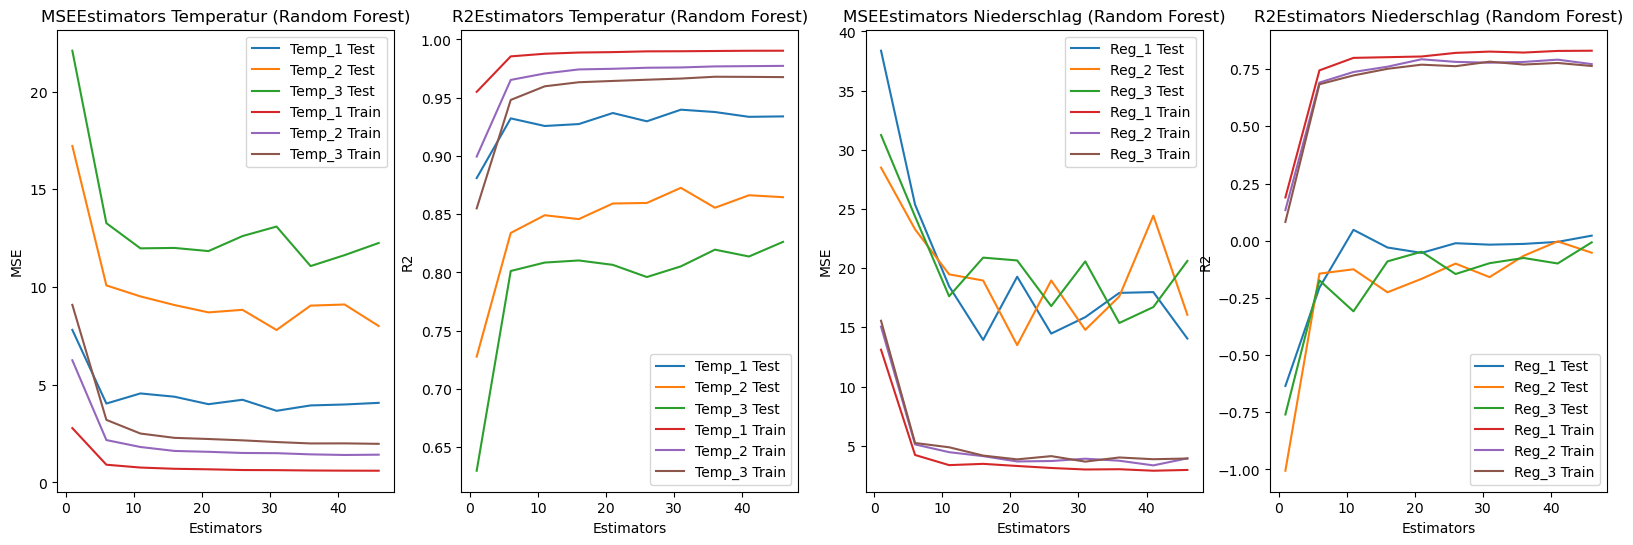

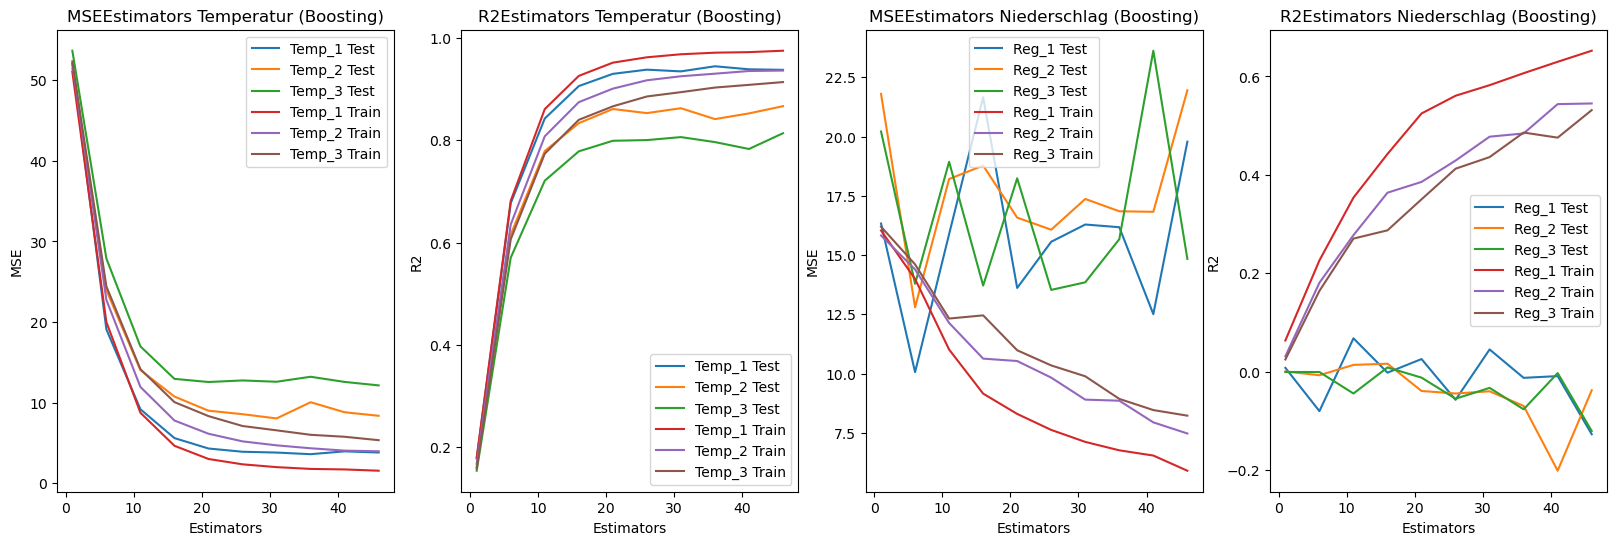

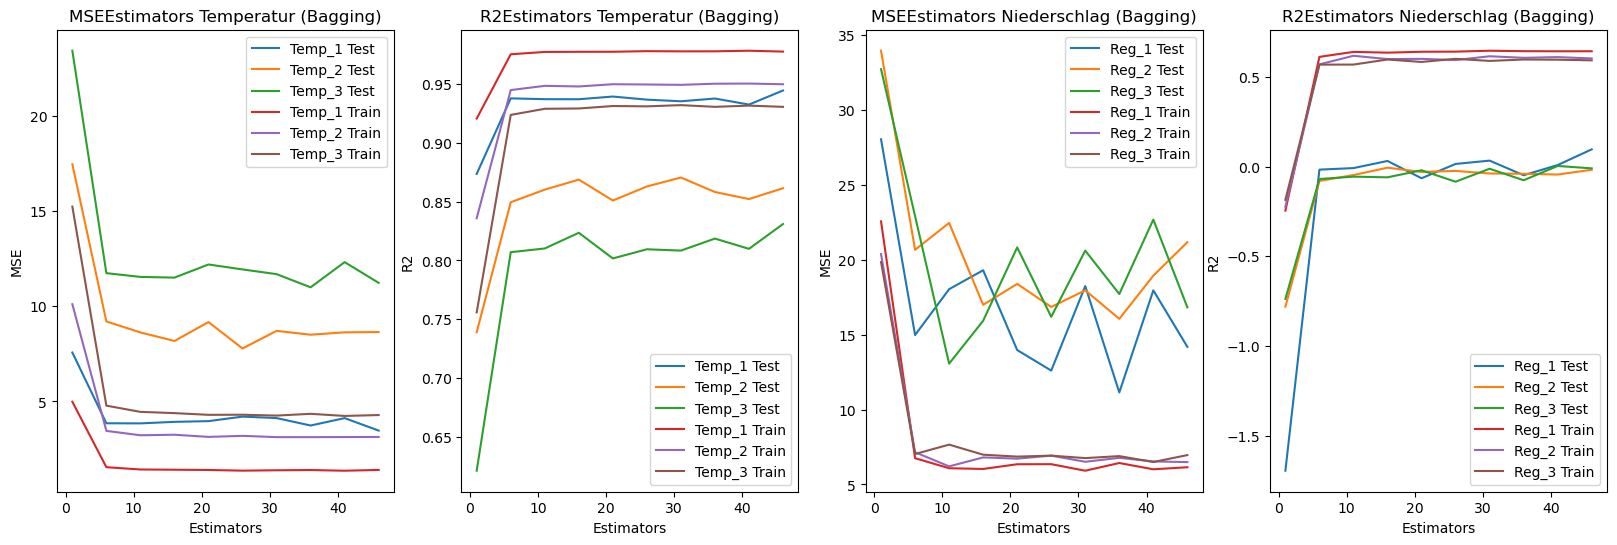

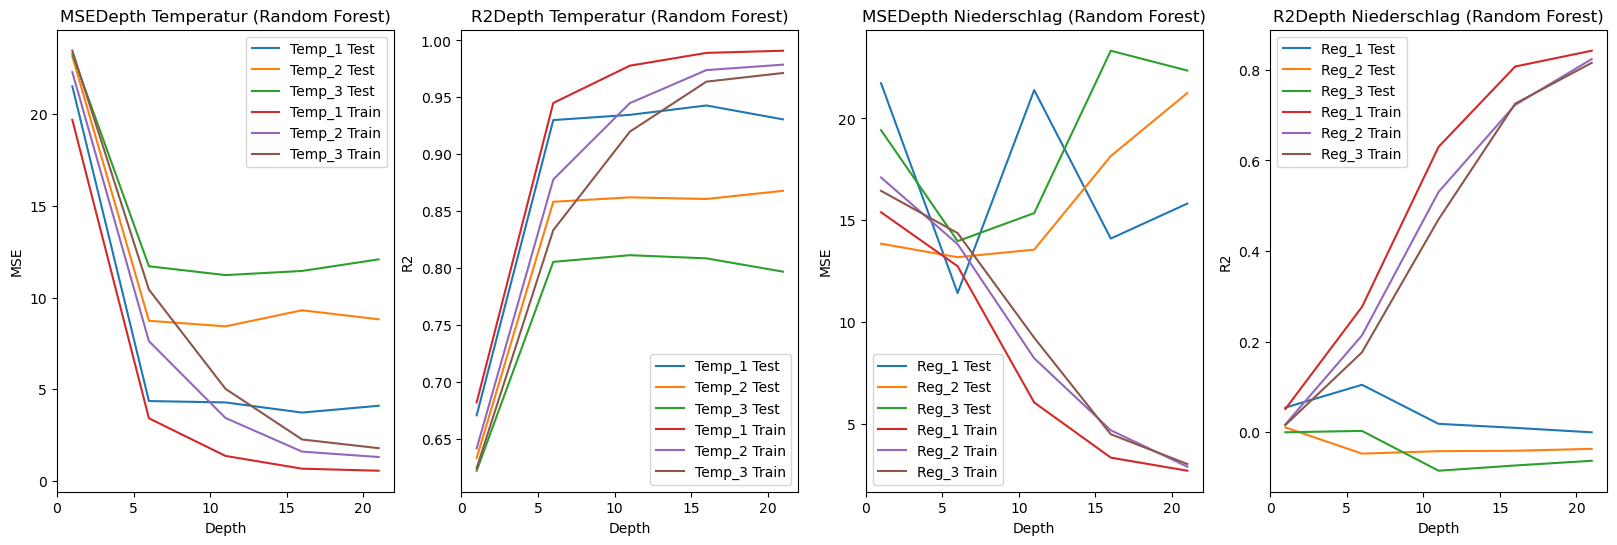

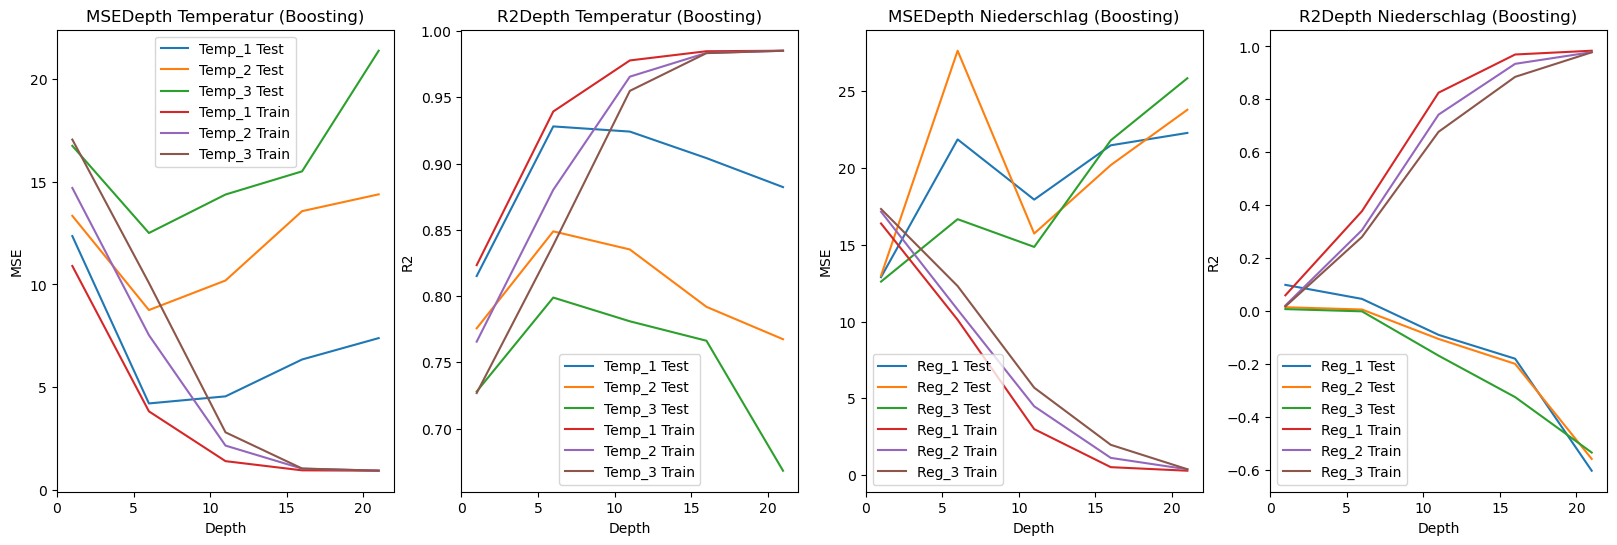

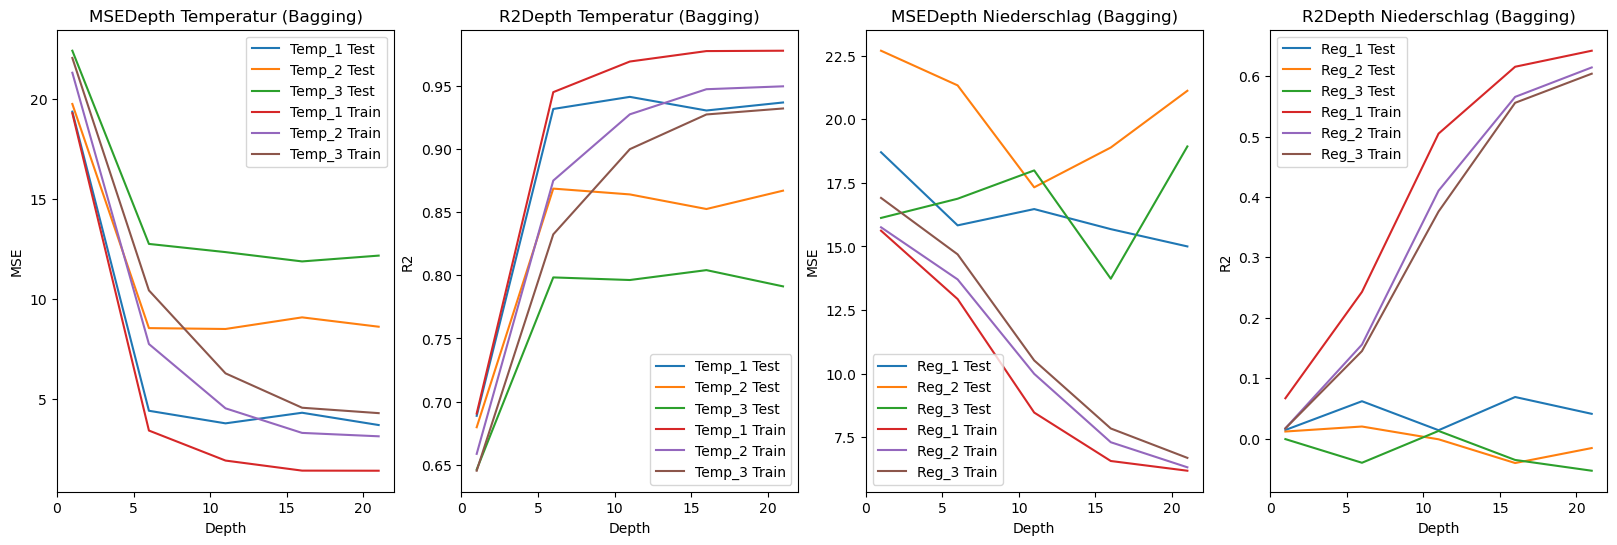

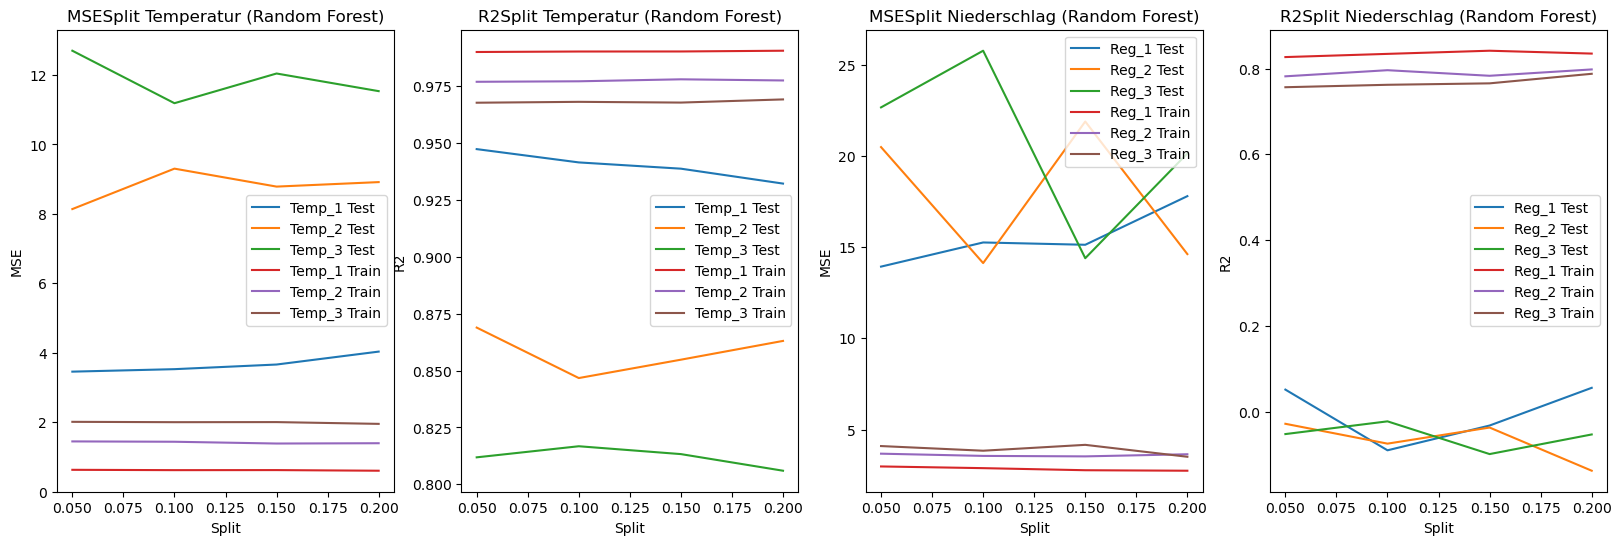

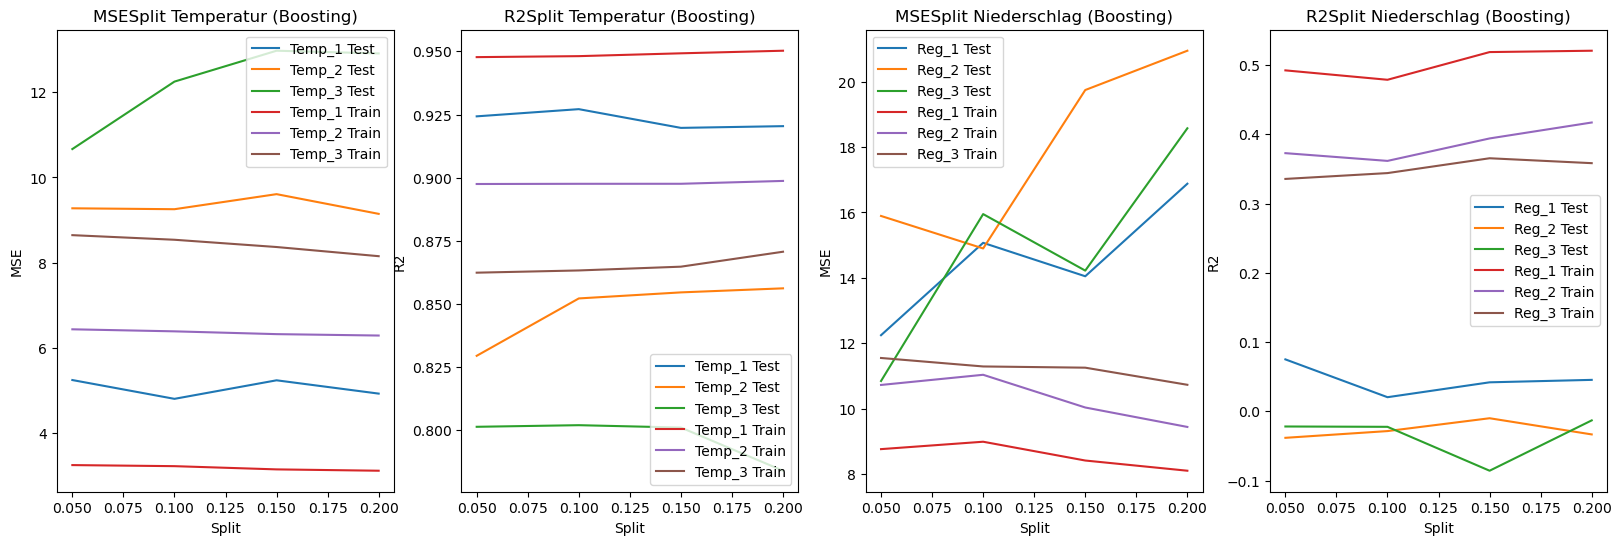

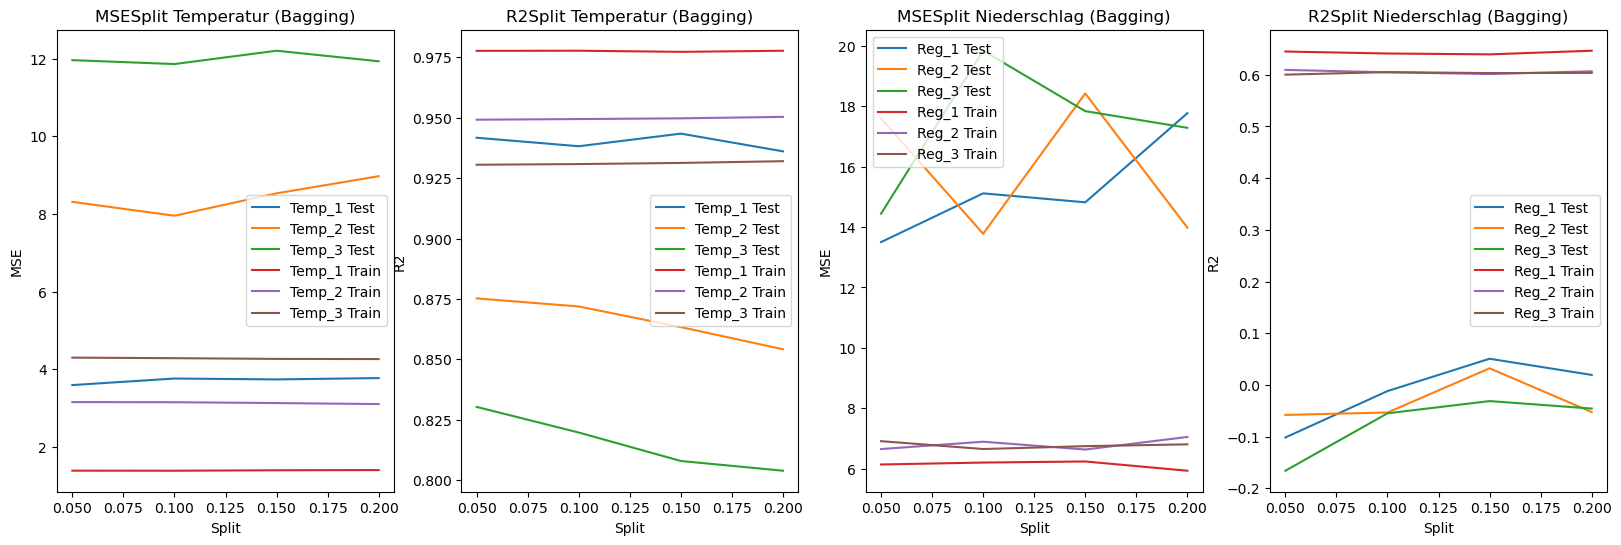

In [8]:
for df, var_name, f_var_name in [(estimatorsCollection, "Estimators", "estimator"), (depthCollection, "Depth", "depth"), (splitCollection, "Split", "split")]:
    for name, sname, fname in zip(["Random Forest", "Boosting", "Bagging"], ["RF", "GB", "BG"], ["forest", "boosting", "bagging"]):
        fig, axs = plt.subplots(1, 4, figsize=(20, 6))
        for i, type, tname, method, method_name in [(0, "mse", "MSE", "Temp", "Temperatur"), (1, "r2", "R2", "Temp", "Temperatur"), (2, "mse", "MSE", "Reg", "Niederschlag"), (3, "r2", "R2", "Reg", "Niederschlag")]:
            df.plot(x="Key", y=[f"{method}_{day}_{type}_{dat}_{sname}" for dat in ["test", "train"] for day in range(1, 4, 1)], ax=axs[i])
            axs[i].set_ylabel(f'{tname}')
            axs[i].set_xlabel(f'{var_name}')
            axs[i].set_title(f'{tname}{var_name} {method_name} ({name})')
            axs[i].legend([f"{method}_{day} {dat}" for dat in ["Test", "Train"] for day in range(1, 4, 1)])
        
        plt.savefig(f'{f_var_name}_variation_{fname}.png')
        plt.show()

In [9]:
#Besten werte finden
best_values = {
    "estimator": {
        "RF": [],
        "GB": [],
        "BG": []
    },
    "depth": {
        "RF": [],
        "GB": [],
        "BG": []
    },
    "split": {
        "RF": [],
        "GB": [],
        "BG": []
    }
}
for df, var_name, f_var_name in [(estimatorsCollection, "Estimators", "estimator"), (depthCollection, "Depth", "depth"), (splitCollection, "Split", "split")]:
    for name, sname, fname in zip(["Random Forest", "Boosting", "Bagging"], ["RF", "GB", "BG"], ["forest", "boosting", "bagging"]):
        for i, type, tname, method, method_name in [(0, "mse", "MSE", "Temp", "Temperatur"), (1, "r2", "R2", "Temp", "Temperatur"), (2, "mse", "MSE", "Reg", "Niederschlag"), (3, "r2", "R2", "Reg", "Niederschlag")]:
            for day in range(1, 4, 1):
                if type == "mse":
                    best_values[f_var_name][sname].append(df.loc[df[f"{method}_{day}_{type}_test_{sname}"].idxmin()]["Key"])
                else:
                    best_values[f_var_name][sname].append(df.loc[(df[f"{method}_{day}_{type}_test_{sname}"] - 1).abs().idxmin()]["Key"])

for type in ["estimator", "depth", "split"]:
    for method in ["RF", "GB", "BG"]:
        liste = best_values[type][method]
        best_values[f'{type}_{method}_avg'] = round(sum(liste) / len(liste), 2)
        print(type, method, best_values[f'{type}_{method}_avg'])

estimator RF 31.42
estimator GB 26.83
estimator BG 34.75
depth RF 9.75
depth GB 3.5
depth BG 13.5
split RF 0.09
split GB 0.11
split BG 0.1


In [24]:
# Einzelnen Methoden Vergleichen
best_scores = {}

for target in ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]:
    print(target)
    y_test, y_pred_test, y_train, y_pred_train, reg = randomForest(X_Val, globals()[f"Y_{target}"], round(best_values[f'estimator_RF_avg']), round(best_values[f'depth_RF_avg']), best_values[f'split_RF_avg'])
    best_scores[f"{target}_mse_RF"] = math.sqrt(mean_squared_error(y_test, y_pred_test))
    best_scores[f"{target}_r2_RF"] = r2_score(y_test, y_pred_test)
    print("Random Forest", "RMSE", best_scores[f"{target}_mse_RF"])
    print("Random Forest", "R2", best_scores[f"{target}_r2_RF"])
    print()
    
    y_test, y_pred_test, y_train, y_pred_train, reg = boosting(X_Val, globals()[f"Y_{target}"], round(best_values[f'estimator_GB_avg']), round(best_values[f'depth_GB_avg']), best_values[f'split_GB_avg'])
    best_scores[f"{target}_mse_GB"] = math.sqrt(mean_squared_error(y_test, y_pred_test))
    best_scores[f"{target}_r2_GB"] = r2_score(y_test, y_pred_test)
    print("Boosting", "RMSE", best_scores[f"{target}_mse_GB"])
    print("Boosting", "R2", best_scores[f"{target}_r2_GB"])
    print()
    
    y_test, y_pred_test, y_train, y_pred_train, reg = bagging(X_Val, globals()[f"Y_{target}"], round(best_values[f'estimator_BG_avg']), round(best_values[f'depth_BG_avg']), best_values[f'split_BG_avg'])
    best_scores[f"{target}_mse_BG"] = math.sqrt(mean_squared_error(y_test, y_pred_test))
    best_scores[f"{target}_r2_BG"] = r2_score(y_test, y_pred_test)
    print("Bagging", "RMSE", best_scores[f"{target}_mse_BG"])
    print("Bagging", "R2", best_scores[f"{target}_r2_BG"])
    print()



Temp_1
Random Forest RMSE 1.8554897327693178
Random Forest R2 0.9421334813018059

Boosting RMSE 2.107132883582529
Boosting R2 0.929248831782488

Bagging RMSE 1.9033526265937073
Bagging R2 0.9449376791687799

Temp_2
Random Forest RMSE 2.8533625911868783
Random Forest R2 0.8689610799574848

Boosting RMSE 2.873504441733231
Boosting R2 0.8592088235974791

Bagging RMSE 2.7437198420497455
Bagging R2 0.8793270863507547

Temp_3
Random Forest RMSE 3.277103333833644
Random Forest R2 0.8446489154604372

Boosting RMSE 3.2544351976173402
Boosting R2 0.8103057295460854

Bagging RMSE 3.2220219828119694
Bagging R2 0.8294151115185753

Reg_1
Random Forest RMSE 4.129583122543555
Random Forest R2 0.023011230827903573

Boosting RMSE 5.074317965883064
Boosting R2 0.05625148349880105

Bagging RMSE 4.129515923965589
Bagging R2 0.0328660251416395

Reg_2
Random Forest RMSE 4.104627329740437
Random Forest R2 -0.07694098299921093

Boosting RMSE 3.7279208210882553
Boosting R2 0.013886630867047556

Bagging RMSE 4.4

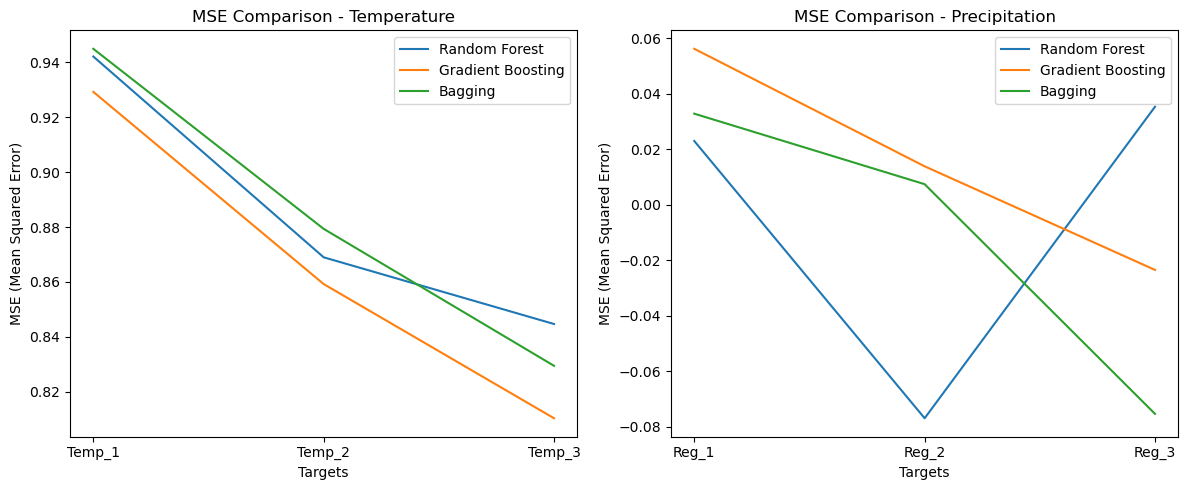

In [26]:
# Vergleichsplot vom Random Forest, 
# Daten für den ersten Plot
targets_temp = ["Temp_1", "Temp_2", "Temp_3"]
mse_RF_temp = [best_scores[f'{target}_r2_RF'] for target in targets_temp]
mse_GB_temp = [best_scores[f'{target}_r2_GB'] for target in targets_temp]
mse_BG_temp = [best_scores[f'{target}_r2_BG'] for target in targets_temp]

# Daten für den zweiten Plot
targets_reg = ["Reg_1", "Reg_2", "Reg_3"]
mse_RF_reg = [best_scores[f'{target}_r2_RF'] for target in targets_reg]
mse_GB_reg = [best_scores[f'{target}_r2_GB'] for target in targets_reg]
mse_BG_reg = [best_scores[f'{target}_r2_BG'] for target in targets_reg]

# Subplots erstellen
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Erster Plot (Temperatur)
axs[0].plot(targets_temp, mse_RF_temp, label='Random Forest')
axs[0].plot(targets_temp, mse_GB_temp, label='Gradient Boosting')
axs[0].plot(targets_temp, mse_BG_temp, label='Bagging')
axs[0].set_xlabel('Targets')
axs[0].set_ylabel('MSE (Mean Squared Error)')
axs[0].set_title('MSE Comparison - Temperature')
axs[0].legend()

# Zweiter Plot (Niederschlag)
axs[1].plot(targets_reg, mse_RF_reg, label='Random Forest')
axs[1].plot(targets_reg, mse_GB_reg, label='Gradient Boosting')
axs[1].plot(targets_reg, mse_BG_reg, label='Bagging')
axs[1].set_xlabel('Targets')
axs[1].set_ylabel('MSE (Mean Squared Error)')
axs[1].set_title('MSE Comparison - Precipitation')
axs[1].legend()

# Subplots anzeigen
plt.tight_layout()
plt.show()

In [12]:
# Vergleich zu den Tatsächlichen Daten



- Datumswerte mal testen, ob da eine relation rauserkannt werden kann